In [ ]:
#To synthesize model and geenrate xclbin files, follow instructions in README. Jupyter notebook cannot be executed normally due to Vivado Y2K22 issue.

In [1]:
import numpy as np
import h5py
import os
from random import shuffle
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
import matplotlib.pyplot as plt
import argparse
from distilled_model import *
#, create_quantized_distilled_model, create_extra_small_quantized_distilled_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import yaml
import math
import tqdm as notebook_tqdm
import hls4ml
import gc
import gdown
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

from hls4ml.model.profiling import numerical
from hls4ml.converters import keras_to_hls
from tensorflow.keras.utils    import to_categorical
from tensorflow.keras.datasets import mnist
from sklearn.datasets        import fetch_openml
from sklearn.preprocessing   import LabelEncoder, StandardScaler
import tensorflow        as tf
import numpy             as np
from tensorflow.keras.models       import Sequential
from tensorflow.keras.optimizers   import Adam
from tensorflow.keras.regularizers import l1
from tensorflow.keras.layers       import Activation, BatchNormalization, Flatten, MaxPool2D, Reshape
from tensorflow.keras.layers       import Dense, Conv2D
#import utils
#from utils.callbacks import all_callbacks
from qkeras.qlayers    import QDense, QActivation
from qkeras            import QConv2D, QConv1D
from qkeras.quantizers import quantized_bits, quantized_relu, quantized_tanh, binary_tanh
from qkeras import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import *
from tensorflow.keras.utils import to_categorical

2022-06-22 14:05:55.882464: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-22 14:05:55.896711: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-22 14:05:55.897426: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
/home/ferroelectric/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
#Add vivado_hls and vitis_hls to path if needed
os.environ['PATH'] = '/home/ferroelectric/Xilinx_2020/Vivado/2020.1/bin:' + os.environ['PATH']
os.environ['PATH'] = '/home/ferroelectric/Xilinx_2020/Vitis/2020.1/bin:' + os.environ['PATH']

In [3]:
def post_process(results_dir, MODEL):
    img = np.load('./data/02_scan_x256_y256_raw.npy')
    img = np.transpose(img,(2,3,0,1))
    data_r = np.copy(img)
    data_r[data_r>1e3]=1e3
    min_ = np.min(data_r)
    max_ = np.max(data_r)

    data_r = 1.0*(data_r-min_)/(max_-min_)

    data_r = data_r.reshape(-1,1,124,124)
    data_r_cut = data_r[:,:,2:122,2:122]
    data_r_cut = data_r_cut.reshape(256,256,120,120)
    X = data_r_cut.reshape(-1, 120,120)

    # generate outputs/targets
    dataset_h5 = h5py.File('./data/unbinned_results.h5','r+')
    rots = np.array(dataset_h5['rotation'])
    scal = np.array(dataset_h5['scale'])
    y = np.concatenate((rots, scal), axis=1)
    sc = StandardScaler()
    _ = sc.fit(y)
    base_8 = np.load('./data/base_8.npy', allow_pickle=1)

    predictions = MODEL.predict(np.ascontiguousarray(X))
    predictions = sc.inverse_transform(predictions)
    predictions.shape
    print('keras pred: ', predictions[1000])
    print('actual:     ', y[1000])

    rotation_, scale_ = predictions[:, 0:2], predictions[:, 2:]

    mse = np.mean((y - predictions)**2)
    print('model MSE on full dataset: ', mse)

    #base=2,loss=0.024
    j=0
    list_new = []
    fig,ax = plt.subplots(1,3,figsize=(20,10))
    for i in range(2):
        if np.sum(base_8[:,i]!=0):
            j+=1
            print(i)
            list_new.append(i)
            ax[i].title.set_text(str(i))
            ax[i].imshow(base_8[:,i].reshape(256,256))
    print('total activated channels: '+str(j))
    ax[2].title.set_text('mean of the sample domain')
    ax[2].imshow(np.mean(data_r_cut.reshape(256,256,-1),axis=2))
    fig.savefig('./models/mlp_average_pool_12b/' + results_dir + '/fig.png')

    fig,ax = plt.subplots(2,2,figsize = (10,10))
    ax[0][0].imshow(rotation_[:,0].reshape(256,256))
    ax[0][1].imshow(rotation_[:,1].reshape(256,256))
    ax[1][0].hist(rotation_[:,0].reshape(-1),200)
    ax[1][1].hist(rotation_[:,1].reshape(-1),200)
    fig.savefig('./models/mlp_average_pool_12b/' + results_dir + '/rotation.png')

    sample_base = base_8[:,1].reshape(256,256)
    scale_0 = np.multiply(sample_base.reshape(256,256),scale_[:,0].reshape(256,256))
    scale_1 = np.multiply(sample_base.reshape(256,256),scale_[:,3].reshape(256,256))

    fig,ax = plt.subplots(2,2,figsize = (10,10))
    clim0 = [1.14,1.19]
    clim1 = [1.1,1.17]
    ax[0][0].imshow(scale_0,clim=clim0)
    ax[0][1].imshow(scale_1,clim=clim1)
    ax[1][0].hist(scale_0.reshape(-1),200,range=clim0)
    ax[1][1].hist(scale_1.reshape(-1),200,range=clim1)
    fig.savefig('./models/mlp_average_pool_12b/' + results_dir + '/scale.png')

    right_tri = np.sqrt(scale_0**2+scale_1**2).reshape(256,256)
    np.save('./models/mlp_average_pool_12b/' + results_dir + '/right_triangle_mlp_average_pool_12b.npy', right_tri)
    fig,ax = plt.subplots(1,2,figsize=(20,10))
    clim=[1.59,1.65]
    ax[0].imshow(right_tri,clim=clim)
    ax[1].hist(right_tri.reshape(-1),200,range=clim)
    fig.savefig('./models/mlp_average_pool_12b/' + results_dir + '/right_triangle.png')
    
def train_mlp():
    history = MODEL.fit(X,y_scal,
                    epochs=115,
                    batch_size = 32,
                    shuffle=True,
                    validation_split = 0.2,)
    
    MODEL.save_weights("./models/mlp_average_pool_12b/model/model_weights.h5")

def train_mlp_large():
    history = MODEL.fit(X,y_scal,
                    epochs=100,
                    batch_size = 32,
                    shuffle=True,
                    validation_split = 0.2,
                    callbacks=callbacks)
    MODEL.save_weights("./models/mlp_average_pool_12b/model/model_large_weights.h5")
    
def load_mlp():
    MODEL.load_weights("./models/mlp_average_pool_12b/model/model_weights.h5")
    
def load_mlp_large():
    MODEL.load_weights("./models/mlp_average_pool_12b/model/model_large_weights.h5")
    
def print_dict(d, indent=0):
    align = 20
    for key, value in d.items():
        print('  ' * indent + str(key), end='')
        if isinstance(value, dict):
            print()
            print_dict(value, indent+1)
        else:
            print(':' + ' ' * (20 - len(key) - 2 * indent) + str(value))

In [19]:
print('loading data...')
img = np.load('./data/02_scan_x256_y256_raw.npy')
img = np.transpose(img,(2,3,0,1)) 
data_r = np.copy(img)
data_r[data_r>1e3]=1e3
min_ = np.min(data_r) 
max_ = np.max(data_r) 
data_r = 1.0*(data_r-min_)/(max_-min_)
data_r = data_r.reshape(-1,1,124,124)
data_r_cut = data_r[:,:,2:122,2:122] 
data_r_cut = data_r_cut.reshape(256,256,120,120) 
data_r_cut = np.rot90(data_r_cut)  
X = data_r_cut.reshape(-1, 120,120)

# generate outputs/targets
dataset_h5 = h5py.File('./data/unbinned_results.h5','r+')
rots = np.array(dataset_h5['rotation'])
scal = np.array(dataset_h5['scale'])
y = np.concatenate((rots, scal), axis=1)

sc = StandardScaler()
y_scal = sc.fit_transform(y)

loading data...


In [5]:
#Configure Training
print('Compiling QKeras Model...')
precision = 12
MODEL = create_mlp_avg_pool(precision)
optimizer = 'adam'
loss = 'mse'

stopping = EarlyStopping(monitor='val_loss',
                             patience = 10)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10,
                                  mode='min', verbose=1, min_delta=0.001,
                                  cooldown=4, min_lr=1e-5)
callbacks=[
        stopping,
        reduce_lr,
    ]

MODEL.compile(optimizer=optimizer, loss=loss)
MODEL.summary()

Compiling QKeras Model...


2022-06-22 14:06:50.835394: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-22 14:06:50.837387: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-22 14:06:50.838125: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-22 14:06:50.838802: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 120, 120, 1)]     0         
                                                                 
 average_pooling2d (AverageP  (None, 30, 30, 1)        0         
 ooling2D)                                                       
                                                                 
 flatten (Flatten)           (None, 900)               0         
                                                                 
 q_dense (QDense)            (None, 64)                57664     
                                                                 
 batch_normalization (BatchN  (None, 64)               256       
 ormalization)                                                   
                                                                 
 q_activation (QActivation)  (None, 64)                0     

In [6]:
load_mlp()

In [7]:
# plot history
try:
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model accuracy')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['training_loss', 'validation_loss'], loc='upper left')
    plt.savefig('./models/mlp_average_pool_12b/keras_model_results/model.png')
except:
    print("Unable to save training history fig")

Unable to save training history fig


## Convert and post-processing

In [8]:
import os
from qkeras.utils import _add_supported_quantized_objects
import argparse
import yaml

In [10]:
results_dir = 'keras_model_results'
post_process(results_dir, MODEL)

keras pred:  [0.93881094 0.34056446 1.1318585  0.         0.         1.199022  ]
actual:      [ 0.99885392 -0.04786232  1.18792486 -0.         -0.          1.14294565]
model MSE on full dataset:  0.011948218340555703
0
1
total activated channels: 2


## Create HLS Model config

In [11]:
#For FIFO Optimization
#hls4ml.model.optimizer.get_optimizer('vivado:fifo_depth_optimization').configure(profiling_fifo_depth=100_000)


print('Compiling HLS Model...')
OUTPUT_DIR = './models/mlp_average_pool_12b/my-hls-test'
PART = 'xcu200-fsgd2104-2-e'
IO_TYPE = 'io_stream'

def config_mlp():
    config = hls4ml.utils.config_from_keras_model(MODEL, granularity='name')
    REUSE_FACTOR = 16
    config['Model']['ReuseFactor'] = REUSE_FACTOR
    config['XilinxPart'] = PART
    config['IOType'] = IO_TYPE
    #config['Flows'] = ['vivado:fifo_depth_optimization']
    # config['SkipOptimizers'] = ['reshape_stream']
    config['SkipOptimizers']= ['relu_merge']
    config['Model']['Strategy'] = 'Resource'
    config['Model']['Precision'] = 'ap_fixed<16,6>'
    config['OutputDir'] = './models/mlp_average_pool_12b/my-hls-test'

    for layer in config['LayerName'].keys():
        config['LayerName'][layer]['Trace'] = True
        config['LayerName'][layer]['ReuseFactor'] = REUSE_FACTOR

    config['LayerName']['q_dense']['Precision']['weight'] = 'ap_fixed<12,4>'
    config['LayerName']['q_dense']['Precision']['bias'] = 'ap_fixed<12,4>'
    config['LayerName']['q_dense_1']['Precision']['weight'] = 'ap_fixed<12,4>'
    config['LayerName']['q_dense_1']['Precision']['bias'] = 'ap_fixed<12,4>'
    config['LayerName']['q_dense_2']['Precision']['weight'] = 'ap_fixed<12,4>'
    config['LayerName']['q_dense_2']['Precision']['bias'] = 'ap_fixed<12,4>'
    config['LayerName']['q_dense_3']['Precision']['weight'] = 'ap_fixed<12,4>'
    config['LayerName']['q_dense_3']['Precision']['bias'] = 'ap_fixed<12,4>'
    return config
    
def config_mlp_large():
    config = hls4ml.utils.config_from_keras_model(MODEL, granularity='name')
    REUSE_FACTOR = 128
    config['Model']['ReuseFactor'] = REUSE_FACTOR
    config['XilinxPart'] = PART
    config['IOType'] = IO_TYPE
    #config['Flows'] = ['vivado:fifo_depth_optimization']
    # config['SkipOptimizers'] = ['reshape_stream']
    config['SkipOptimizers']= ['relu_merge']
    config['Model']['Strategy'] = 'Resource'
    config['Model']['Precision'] = 'ap_fixed<16,6, AP_RND, AP_SAT>'
    config['OutputDir'] = './models/mlp_average_pool_12b/my-hls-test'

    for layer in config['LayerName'].keys():
        config['LayerName'][layer]['Trace'] = True
        config['LayerName'][layer]['ReuseFactor'] = REUSE_FACTOR

    config['LayerName']['q_dense']['Precision']['weight'] = 'ap_fixed<12,4, AP_RND, AP_SAT>'
    config['LayerName']['q_dense']['Precision']['bias'] = 'ap_fixed<12,4, AP_RND, AP_SAT>'
    config['LayerName']['q_dense_1']['Precision']['weight'] = 'ap_fixed<12,4, AP_RND, AP_SAT>'
    config['LayerName']['q_dense_1']['Precision']['bias'] = 'ap_fixed<12,4, AP_RND, AP_SAT>'
    config['LayerName']['q_dense_2']['Precision']['weight'] = 'ap_fixed<12,4, AP_RND, AP_SAT>'
    config['LayerName']['q_dense_2']['Precision']['bias'] = 'ap_fixed<12,4, AP_RND, AP_SAT>'
    config['LayerName']['q_dense_3']['Precision']['weight'] = 'ap_fixed<12,4, AP_RND, AP_SAT>'
    config['LayerName']['q_dense_3']['Precision']['bias'] = 'ap_fixed<12,4, AP_RND, AP_SAT>'
    config['LayerName']['q_dense_4']['Precision']['weight'] = 'ap_fixed<12,4, AP_RND, AP_SAT>'
    config['LayerName']['q_dense_4']['Precision']['bias'] = 'ap_fixed<12,4, AP_RND, AP_SAT>'
    return config
config = config_mlp()


BOARD = 'alveo-u200'
CLOCK_PERIOD = 5
BACKEND = 'VivadoAccelerator'

cfg = hls4ml.converters.create_config(board=BOARD, clock_period= CLOCK_PERIOD, part=PART, backend=BACKEND)
cfg['HLSConfig'] = config
cfg['AcceleratorConfig']['Driver']    = 'python'
cfg['AcceleratorConfig']['Board']     = 'alveo-u200'
cfg['AcceleratorConfig']['Interface'] = 'axi_stream'
#cfg['AcceleratorConfig']['Interface'] = 'axi_lite'
#cfg['AcceleratorConfig']['Interface'] = 'axi_master'
cfg['AcceleratorConfig']['Precision']['Input']  = 'float'
cfg['AcceleratorConfig']['Precision']['Output'] = 'float'
cfg['AcceleratorConfig']['Platform'] = 'xilinx_u200_xdma_201830_2'
cfg['IOType']= 'io_stream'
cfg['KerasModel'] = MODEL
cfg['OutputDir'] ='./models/mlp_average_pool_12b/my-hls-test'

print("-----------------------------------")
print_dict(cfg)
print("-----------------------------------")
HLS_MODEL = hls4ml.converters.keras_to_hls(cfg)
#hls4ml.model.optimizer.get_optimizer('output_rounding_saturation_mode').configure(layers=[])

HLS_MODEL.compile()

# HLS_MODEL = hls4ml.converters.convert_from_keras_model(MODEL,
#                                                     hls_config=config,
#                                                     output_dir=OUTPUT_DIR,
#                                                     part=PART,
#                                                     io_type=IO_TYPE)
# HLS_MODEL.compile()

Compiling HLS Model...
Interpreting Model
Topology:
Layer name: input_1, layer type: Input
Layer name: average_pooling2d, layer type: AveragePooling2D
Layer name: q_dense, layer type: QDense
  -> Activation (linear), layer name: q_dense
Layer name: batch_normalization, layer type: BatchNormalization
Layer name: q_activation, layer type: QActivation
  -> Activation (quantized_relu), layer name: q_activation
Layer name: q_dense_1, layer type: QDense
  -> Activation (linear), layer name: q_dense_1
Layer name: batch_normalization_1, layer type: BatchNormalization
Layer name: q_activation_1, layer type: QActivation
  -> Activation (quantized_relu), layer name: q_activation_1
Layer name: q_dense_2, layer type: QDense
  -> Activation (linear), layer name: q_dense_2
Layer name: batch_normalization_2, layer type: BatchNormalization
Layer name: q_activation_2, layer type: QActivation
  -> Activation (quantized_relu), layer name: q_activation_2
Layer name: q_dense_3, layer type: QDense
  -> Activ

In [12]:
results_dir = 'hls_model_results'
post_process(results_dir, HLS_MODEL)

keras pred:  [0.94416597 0.32518469 1.12803744 0.         0.         1.19842242]
actual:      [ 0.99885392 -0.04786232  1.18792486 -0.         -0.          1.14294565]
model MSE on full dataset:  0.011012934809013537
0
1
total activated channels: 2


## Profiling to Compare Layer Outputs

Saving profiling figures...
Interpreting Model
Topology:
Layer name: input_1, layer type: InputLayer, input shapes: [[None, 120, 120, 1]], output shape: [None, 120, 120, 1]
Layer name: average_pooling2d, layer type: AveragePooling2D, input shapes: [[None, 120, 120, 1]], output shape: [None, 30, 30, 1]
Layer name: flatten, layer type: Reshape, input shapes: [[None, 30, 30, 1]], output shape: [None, 900]
Layer name: q_dense, layer type: QDense, input shapes: [[None, 900]], output shape: [None, 64]
Layer name: batch_normalization, layer type: BatchNormalization, input shapes: [[None, 64]], output shape: [None, 64]
Layer name: q_activation, layer type: Activation, input shapes: [[None, 64]], output shape: [None, 64]
Layer name: q_dense_1, layer type: QDense, input shapes: [[None, 64]], output shape: [None, 32]
Layer name: batch_normalization_1, layer type: BatchNormalization, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: q_activation_1, layer type: Activation, input shap

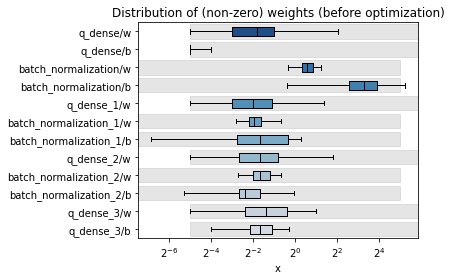

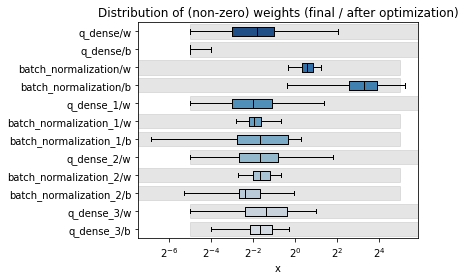

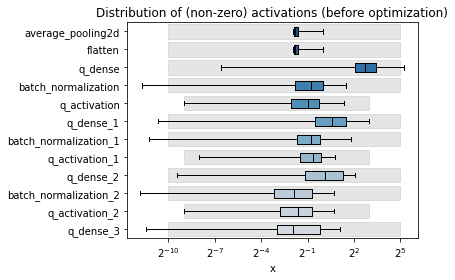

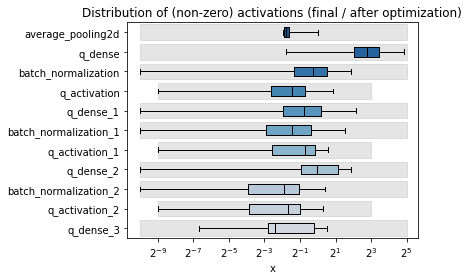

In [20]:
print('Saving profiling figures...')
X_test = np.ascontiguousarray(X)
%matplotlib inline
plots = hls4ml.model.profiling.numerical(model=MODEL, hls_model = HLS_MODEL, X=X_test[0:100])
for i, plot in enumerate(plots):
    plot.savefig(f'./models/mlp_average_pool_12b/profiling/profiling_{i}.png')

In [21]:
## Trace Model
keras_trace = hls4ml.model.profiling.get_ymodel_keras(MODEL, X_test[0:100])
y_hls, hls4ml_trace = HLS_MODEL.trace(X_test[0:100])

Processing input_1 in Keras model...
Processing average_pooling2d in Keras model...
Processing flatten in Keras model...
Processing q_dense in Keras model...
Processing batch_normalization in Keras model...
Processing q_activation in Keras model...
Processing q_dense_1 in Keras model...
Processing batch_normalization_1 in Keras model...
Processing q_activation_1 in Keras model...
Processing q_dense_2 in Keras model...
Processing batch_normalization_2 in Keras model...
Processing q_activation_2 in Keras model...
Processing q_dense_3 in Keras model...
Done taking outputs for Keras model.
Recompiling myproject with tracing
Writing HLS project
Done
Writing HLS project
Done


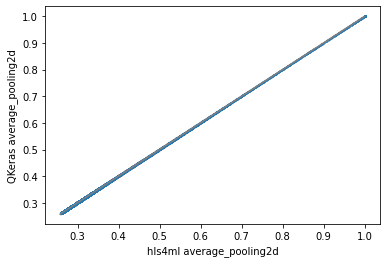

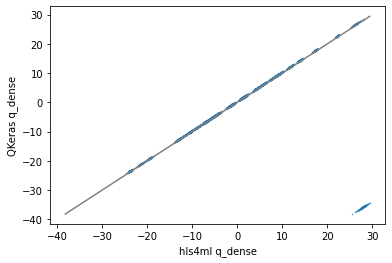

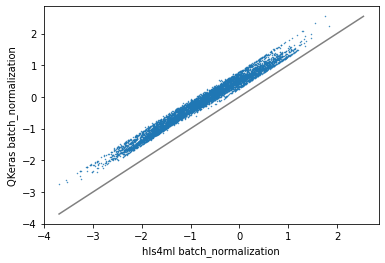

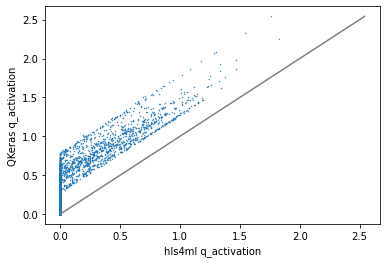

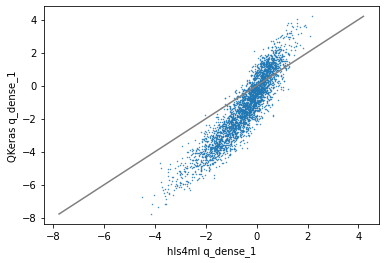

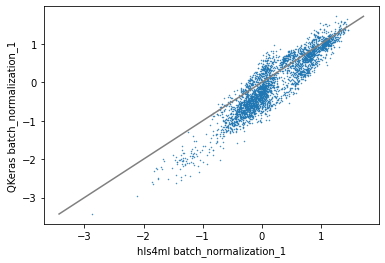

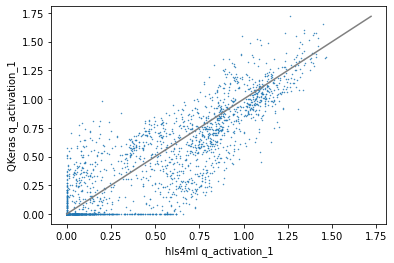

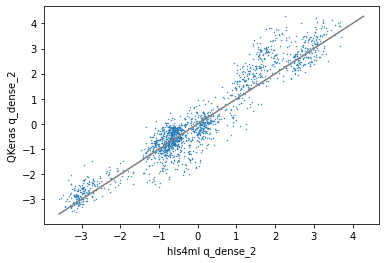

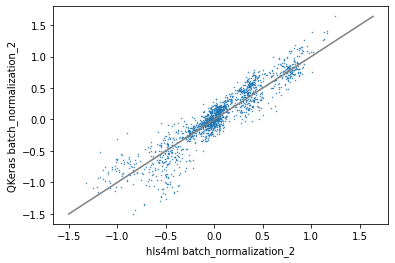

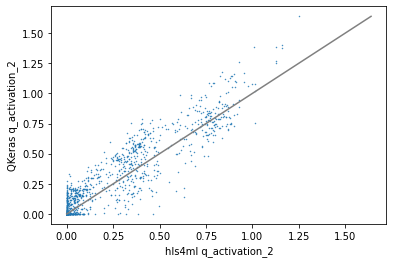

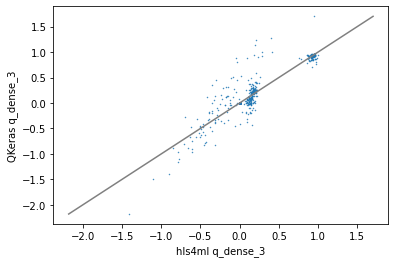

In [22]:
for layer in hls4ml_trace.keys():
            plt.figure()
            klayer = layer
            if '_alpha' in layer:
                klayer = layer.replace('_alpha', '')
            plt.scatter(hls4ml_trace[layer].flatten(), keras_trace[klayer].flatten(), s=0.2)
            min_x = min(np.amin(hls4ml_trace[layer]), np.amin(keras_trace[klayer]))
            max_x = max(np.amax(hls4ml_trace[layer]), np.amax(keras_trace[klayer]))
            plt.plot([min_x, max_x], [min_x, max_x], c='gray')
            plt.xlabel('hls4ml {}'.format(layer))
            plt.ylabel('QKeras {}'.format(klayer))
            plt.savefig(os.path.join('./models/mlp_average_pool_12b/profiling/', 'profiling_{}.png'.format(layer)), dpi=300)

In [ ]:
print('loading data...')
img = np.load('./data/02_scan_x256_y256_raw.npy')
img = np.transpose(img,(2,3,0,1)) 
data_r = np.copy(img)
data_r[data_r>1e3]=1e3
min_ = np.min(data_r) 
max_ = np.max(data_r) 
data_r = 1.0*(data_r-min_)/(max_-min_)
data_r = data_r.reshape(-1,1,124,124)
data_r_cut = data_r[:,:,2:122,2:122] 
data_r_cut = data_r_cut.reshape(256,256,120,120) 
data_r_cut = np.rot90(data_r_cut)  
X = data_r_cut.reshape(-1, 120,120)

# generate outputs/targets
dataset_h5 = h5py.File('./data/unbinned_results.h5','r+')
rots = np.array(dataset_h5['rotation'])
scal = np.array(dataset_h5['scale'])
y = np.concatenate((rots, scal), axis=1)

sc = StandardScaler()
y_scal = sc.fit_transform(y)

In [23]:
del img
del data_r
del data_r_cut
del X
del dataset_h5
del rots
del scal
del y
del sc
del y_scal
gc.collect()

277106

## Build Model

In [ ]:
#To build normally
print('Synthesizing HLS and Building IP Block...')
HLS_MODEL.build(csim=False,synth=True, vsynth=True, export=True)

#To build with FIFO Optimization
# HLS_MODEL.build(reset=False, csim=True, synth=True, cosim=True, validation=True, export=True, vsynth=True)

## Build xclbin for deployment

In [ ]:
os.makedirs('xclbin_files', exist_ok=True)

In [ ]:
print('Generating xclbin files...')
!source /opt/xilinx/xrt/setup.sh

hls4ml.backends.VivadoAcceleratorBackend.make_xclbin(HLS_MODEL, 'xilinx_u200_xdma_201830_2')